# Reorient in flow

In this notebook, we visualize the reorientation of one bacterium in the flow field generated by a neighboring bacterium. 

## 0 Packages

In [390]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects # Import patheffects

def draw_ecoli(ax, center_x, center_y, angle_degrees, length, width,
               face_color='green', edge_color='darkgreen', ellipse_linewidth=1, alpha=0.8, zorder=2,
               add_glow=False, glow_color='yellow', glow_linewidth=5, glow_alpha=0.5):
    """
    Draws an E. coli like shape (an ellipse) on the given axes.

    Args:
        ax: Matplotlib axes object.
        center_x, center_y: Center point of the E. coli.
        angle_degrees: Orientation angle of the E. coli's major axis (in degrees)
                       with respect to the positive x-axis.
        length: Length of the E. coli (major axis of the ellipse).
        width: Width of the E. coli (minor axis of the ellipse).
        face_color: Fill color of the E. coli.
        edge_color: Border color of the E. coli.
        ellipse_linewidth: Linewidth of the E. coli's primary border.
        alpha: Transparency of the main E. coli shape (fill and edge).
        zorder: Plotting order.
        add_glow: If True, adds a glow effect to the boundary.
        glow_color: Color of the glow effect.
        glow_linewidth: Linewidth of the glow effect stroke.
                        For a visible glow, this should be larger than ellipse_linewidth.
        glow_alpha: Transparency of the glow effect.
    """
    # Matplotlib's Ellipse takes width (full width of major axis) and height (full height of minor axis)
    # and an angle for rotation.
    ecoli_shape = mpatches.Ellipse((center_x, center_y),
                                   width=length,  # Corresponds to the length of E. coli
                                   height=width, # Corresponds to the width of E. coli
                                   angle=angle_degrees,
                                   facecolor=face_color,
                                   edgecolor=edge_color,
                                   linewidth=ellipse_linewidth, # Set the primary edge linewidth
                                   alpha=alpha, # Overall alpha for the main shape
                                   zorder=zorder)

    if add_glow:
        # The Stroke path effect creates an outline.
        # By drawing it first, then path_effects.Normal() (which draws the original patch),
        # the stroke appears behind the original patch's edge, creating a halo/glow.
        # The glow_linewidth should be larger than ellipse_linewidth for the glow to extend outwards.
        path_effect = [
            path_effects.Stroke(linewidth=glow_linewidth,
                                foreground=glow_color,
                                alpha=glow_alpha), # Alpha specific to the glow
            path_effects.Normal() # Draws the original patch (fill and its own edge)
        ]
        ecoli_shape.set_path_effects(path_effect)

    ax.add_patch(ecoli_shape)
    return ecoli_shape # It's good practice to return the patch object

(-1.0, 1.0, -0.2, 0.2)

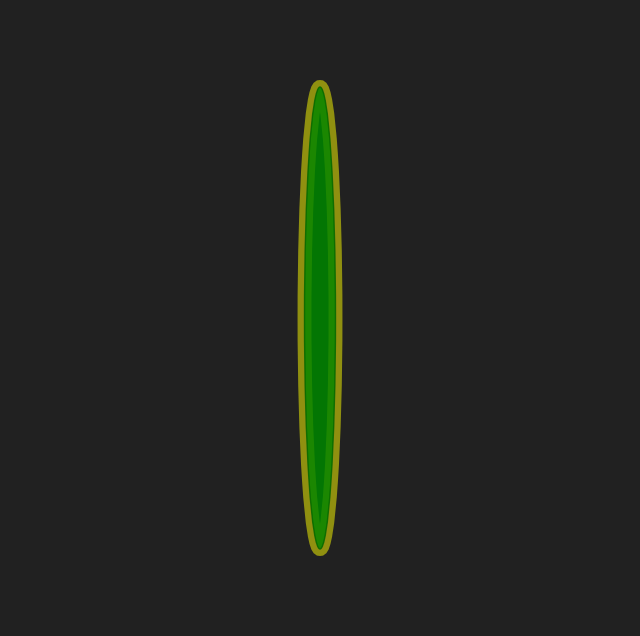

In [403]:
fig,ax = plt.subplots(figsize=(8, 8), facecolor="#212121")
draw_ecoli(ax, center_x=0, center_y=0, angle_degrees=90, length=.3, width=.1, add_glow=True, glow_linewidth=10)
ax.set_xlim(-1, 1)
ax.set_ylim(-.2, .2)
ax.axis("off")

## 1 Dipole flow field

The flow field generated by a force dipole can be written as

$$
\textbf{u}(\textbf{x}) = \frac{Fl}{8\pi\mu \|\textbf{x}\|^2} \left[ \frac{3(\textbf{d} \cdot \textbf{x})^2}{\|\textbf{x}\|^2} - 1 \right] \frac{\textbf{x} }{\|\textbf{x}\|}
$$

where $A = \frac{Fl}{8\pi\mu}$, $\textbf{d}$ is the direction unit vector of the force dipole. 

In [321]:
lim = 10
X, Y = np.meshgrid(np.linspace(-lim, lim), np.linspace(-lim, lim)) 

In [322]:
x = np.stack([X, Y], axis=0) # um

In [323]:
mu = 1e-3 # pN / um^2
F = 0.42 # pN / um
l = 1.9 # um
A = F * l / (8 * np.pi * mu)
d = np.array([0, 1]) # pN * um

In [324]:
d = d[:, np.newaxis, np.newaxis]
d_dot_x = (d * x).sum(axis=0, keepdims=True)
x_norm = np.linalg.norm(x, axis=0, keepdims=True)

In [325]:
u = A / x_norm**2 * ( 3 * d_dot_x**2 / x_norm**2 - 1 ) * x / x_norm

In [326]:
# exclude the near field
u[:, np.abs(x_norm).squeeze() < 2] = np.nan

In [327]:
magnitude = np.hypot(u[0], u[1])

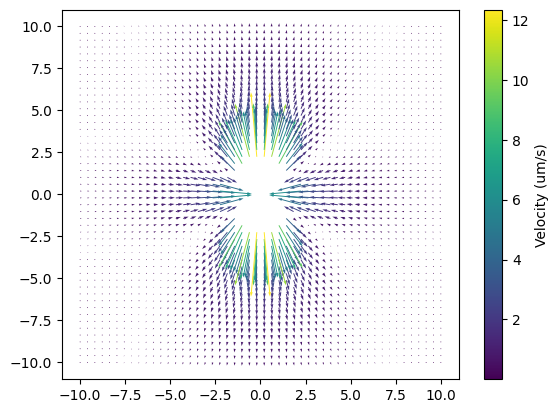

In [328]:
plt.quiver(X, Y, u[0], u[1], magnitude, cmap="viridis")
plt.colorbar(label="Velocity (um/s)")

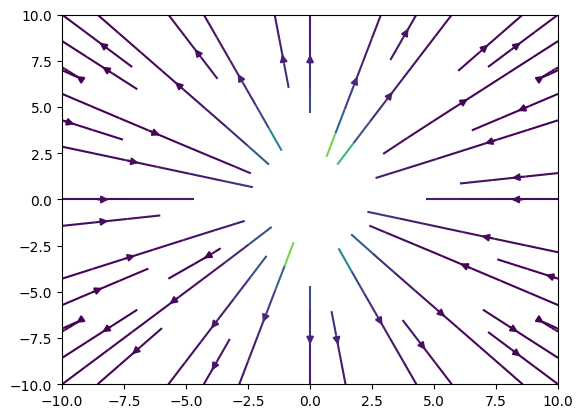

In [171]:
plt.streamplot(X, Y, u[0], u[1], .5, color=magnitude, cmap='viridis')

In [329]:
def compute_vorticity(r, d2):
    """
    Computes the vorticity based on the given parameters.

    Args:
        r (np.ndarray): Position vector.
        d2 (np.ndarray): Second derivative of the position vector.

    Returns:
        float: Vorticity value.
    """
    # Assuming d2 is a 2D vector
    r_norm = np.linalg.norm(r)
    omega_z = 6 * A * np.dot(r, d2) / (r_norm**5) * np.cross(r, d2)
    return omega_z

In [343]:
w = np.zeros((x.shape[1], (x.shape[2])))
for i in range(x.shape[1]):
    for j in range(x.shape[2]):
        w[i, j] = compute_vorticity(x[:, i, j], d2)

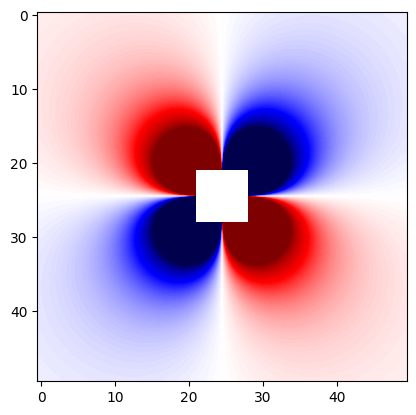

In [344]:
w[np.abs(x_norm).squeeze() < 1] = np.nan
plt.imshow(w, vmin=-1, vmax=1, cmap="seismic", interpolation="Spline16")

## 2 Rotation of a rod in a simple shear flow field

$$
\dot{d}_i = \frac{1}{2} \epsilon_{ijk} \omega_j d_k + \Gamma d_k E_{kj} (\delta_{ji} - d_j d_i)
$$

In [216]:
def calculate_d_dot(d, omega_z, Gamma, E_tensor):
    """
    Calculates d_dot based on the 2D formulation.

    Args:
        d (np.ndarray): 2D unit vector d, shape (2,).
        omega_z (float): Vorticity component.
        Gamma (float): Scalar parameter.
        E_tensor (np.ndarray): 2x2 strain rate tensor, shape (2,2).

    Returns:
        np.ndarray: d_dot vector, shape (2,).
    """
    # Term 1: Rotation by vorticity
    # Rotation matrix for omega_z
    R_omega = np.array([[0, -1],
                        [1,  0]])
    term1 = 0.5 * omega_z * R_omega @ d

    # Term 2: Alignment by strain
    Ed = E_tensor @ d
    Ed_dot_d = np.dot(Ed, d)
    term2 = Gamma * (Ed - Ed_dot_d * d)

    d_dot = term1 + term2
    return d_dot

# --- Parameters for visualization ---
omega_z = 1.0  # Example vorticity
lambda_ = 1.5 / 0.5
Gamma = (lambda_**2 - 1) / (lambda_**2 + 1)     # Example shape/material parameter (related to Jeffery's orbit B parameter)

# Example Strain Rate Tensor E (symmetric)
# E_tensor = np.array([[0.5, 0.1],  # E00, E01
#                      [0.1, -0.5]]) # E10, E11

# Simple shear flow E_ij = [[0, gamma_dot], [0, 0]] (symmetric part is [[0, gamma_dot/2],[gamma_dot/2,0]])
# For pure strain:
# E_tensor = np.array([[0.5, 0.0],
#                      [0.0, -0.5]]) # Pure extension/compression

# Shear flow example (symmetric part of velocity gradient tensor)
# For velocity field u = G*y, v = 0 => Grad_v = [[0, G], [0,0]]
# E = 0.5 * (Grad_v + Grad_v.T) = [[0, G/2], [G/2, 0]]
# Omega (vorticity tensor) = 0.5 * (Grad_v - Grad_v.T) = [[0, G/2], [-G/2, 0]]
# omega_z for this flow would correspond to -G (if omega_z is 2 * Omega_10) or G
# Let's use a direct definition for E and omega_z for clarity in the equation
# Let's use a simple shear flow's symmetric part for E
shear_rate = 10.0
E_tensor = np.array([[0.0, shear_rate / 2.0],
                     [shear_rate / 2.0, 0.0]])
# And set omega_z based on typical relation to shear rate (e.g., omega_z = -shear_rate for Jeffery's orbits context)
omega_z = -shear_rate # For simple shear u_x = G*y, vorticity is -G

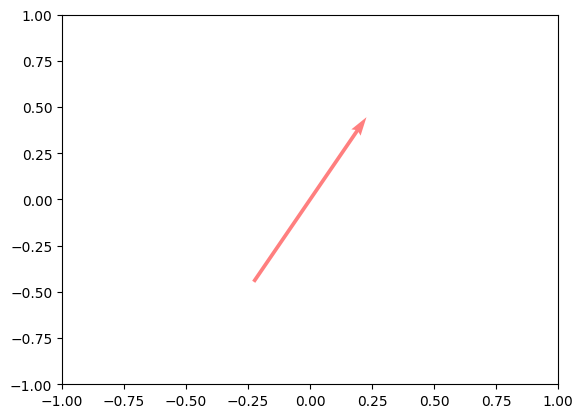

In [218]:
start_angle = -0.5
dt = .1
d_vec = np.array([np.cos(start_angle), np.sin(start_angle)])  # Initial unit vector
for i in range(100):
    d_dot = calculate_d_dot(d_vec, omega_z, Gamma, E_tensor)
    d_vec += d_dot * dt
    d_vec /= np.linalg.norm(d_vec)  # Normalize to keep it a unit vector
    plt.quiver(0, 0, d_vec[0], d_vec[1], pivot="middle", angles='xy', scale_units='xy', scale=1, color='red', alpha=0.5)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.pause(0.1)
    clear_output(wait=True)
    # print(np.linalg.norm(d_vec))

## 3 Rotation of a rod in a dipole flow

Now, let's use more realistic vorticity field and and rate of strain tensor. 

$$
\omega_i = 6A \frac{(\hat{\mathbf{r}} \cdot \mathbf{d}')}{|\mathbf{r}|^3} \epsilon_{ijk} d'_j \hat{r}_k
$$

$$
E_{ij} = \frac{A}{|\mathbf{r}|^3} \left\{ [3(\hat{\mathbf{r}} \cdot \mathbf{d}')^2 - 1]\delta_{ij} + 3(\hat{\mathbf{r}} \cdot \mathbf{d}')(d'_j \hat{r}_i + d'_i \hat{r}_j) \right.
$$
$$
\left. \qquad - [15(\hat{\mathbf{r}} \cdot \mathbf{d}')^2 - 3]\hat{r}_i \hat{r}_j \right\}
$$


In [219]:
def compute_vorticity(r, d2):
    """
    Computes the vorticity based on the given parameters.

    Args:
        r (np.ndarray): Position vector.
        d2 (np.ndarray): Second derivative of the position vector.

    Returns:
        float: Vorticity value.
    """
    # Assuming d2 is a 2D vector
    r_norm = np.linalg.norm(r)
    omega_z = 6 * A * np.dot(r, d2) / (r_norm**5) * np.cross(r, d2)
    return omega_z

In [227]:
def compute_strain_rate_tensor(r, d2):
    """
    Computes the strain rate tensor based on the given parameters.

    Args:
        r (np.ndarray): Position vector.
        d2 (np.ndarray): Second derivative of the position vector.

    Returns:
        np.ndarray: Strain rate tensor.
    """
    # Assuming d2 is a 2D vector
    r_norm = np.linalg.norm(r)
    k = np.dot(r, d2) / r_norm
    E_tensor = A / r_norm**3 * (
        (3 * k**2 - 1) * np.identity(2)
        + 3 * k * (np.outer(d2,r) + np.outer(d2, r).T) / r_norm
        + (15 * k**2 - 3) * np.outer(r, r) / r_norm**2
    )
    return E_tensor

In [259]:
r = np.array([.5, 0])  # Example position vector
d2 = np.array([0, 1])  # Example second derivative vector
# Example usage
omega_z = compute_vorticity(r, d2)
E_tensor = compute_strain_rate_tensor(r, d2)

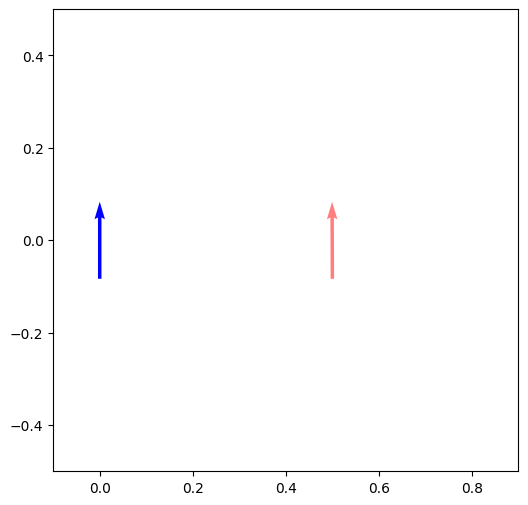

In [268]:
start_angle = 0.1
dt = .1
d_vec = np.array([np.cos(start_angle), np.sin(start_angle)])  # Initial unit vector
for i in range(30):
    plt.figure(figsize=(6, 6))
    d_dot = calculate_d_dot(d_vec, omega_z, Gamma, E_tensor)
    d_vec += d_dot * dt
    d_vec /= np.linalg.norm(d_vec)  # Normalize to keep it a unit vector
    plt.quiver(0, 0, d2[0], d2[1], pivot="middle", angles='xy', scale_units='xy', scale=6, color='blue', alpha=1)
    plt.quiver(r[0], r[1], d_vec[0], d_vec[1], pivot="middle", angles='xy', scale_units='xy', scale=6, color='red', alpha=0.5)
    plt.xlim(-.1, .9)
    plt.ylim(-.5, .5)
    # plt.axis("equal")
    plt.pause(0.01)
    clear_output(wait=True)

## 4 Multiple rods

In [294]:
N = 10
r_list = np.zeros((N, 2))
r_list[:, 0] = np.linspace(.4, 2, N)
r_list[:, 1] = .0
d2 = np.array([0, 1])  # Example second derivative vector
omega_z_list = []
E_tensor_list = []

for r in r_list:
    omega_z = compute_vorticity(r, d2)
    E_tensor = compute_strain_rate_tensor(r, d2)
    omega_z_list.append(omega_z)
    E_tensor_list.append(E_tensor)

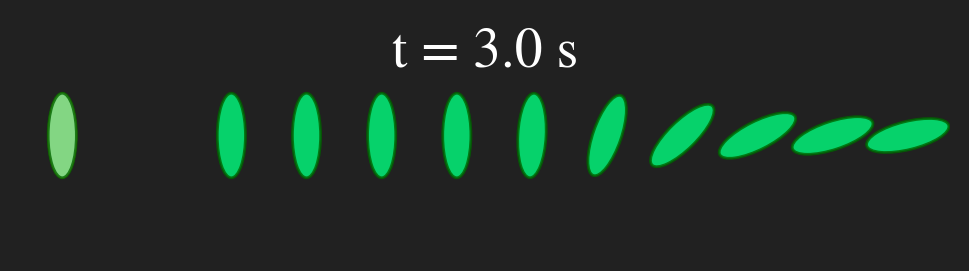

In [ ]:
# simulation parameters
start_angle = 0.1
dt = .01
Dr = 0.1
ecoli_length = 0.2
ecoli_width = ecoli_length / 3.0 # Typical aspect ratio for E. coli (approx 3:1 to 5:1)
########################

### control glow effect
ampl = 5
T = 0.5
Tstep = int(T / dt)
########################

d_vec_list = []

for i in range(N):
    d_vec_list.append(np.array([np.cos(start_angle), np.sin(start_angle)]))  # Initial unit vector

for i in range(300):
    fig, ax = plt.subplots(figsize=(6, 1.5), dpi=200, facecolor="#212121")
    angles_rad = np.arctan2(d2[1], d2[0])
    angles_deg = np.degrees(angles_rad) # Ellipse angle is in degrees
    draw_ecoli(ax, 0, 0, angles_deg,
                ecoli_length, ecoli_width,
                face_color='springgreen', edge_color='darkgreen',
                add_glow=True, glow_linewidth=ampl*np.sin(i/Tstep*2*np.pi), glow_alpha=0.5*(np.sin(i/Tstep*2*np.pi)+1.))
    for j in range(N):
        d_dot = calculate_d_dot(d_vec_list[j], omega_z_list[j], Gamma, E_tensor_list[j])
        d_vec_list[j] += d_dot * dt
        d_vec_list[j] /= np.linalg.norm(d_vec_list[j])  # Normalize to keep it a unit vector
        angles_rad = np.arctan2(d_vec_list[j][1], d_vec_list[j][0])
        angles_deg = np.degrees(angles_rad) # Ellipse angle is in degrees
        draw_ecoli(ax, r_list[j][0], r_list[j][1], angles_deg,
                   ecoli_length, ecoli_width,
                   face_color='springgreen', edge_color='darkgreen')
    
    # plt.ylim(-1.1, 1.1)
    plt.annotate(f"t = {i*dt:.1f} s", xy=(0.5, 0.8), xycoords="axes fraction", fontsize=20, ha="center", fontfamily="STIXGeneral", color="white")
    plt.axis("equal")
    plt.axis("off")
    plt.xlim(-.1, 2.1)
    fig.savefig(os.path.join(r"C:\Users\zl948\Documents\flow_align_animation\no_noise", f"{i:04d}.png"))
    plt.pause(0.01)
    clear_output(wait=True)
    # break

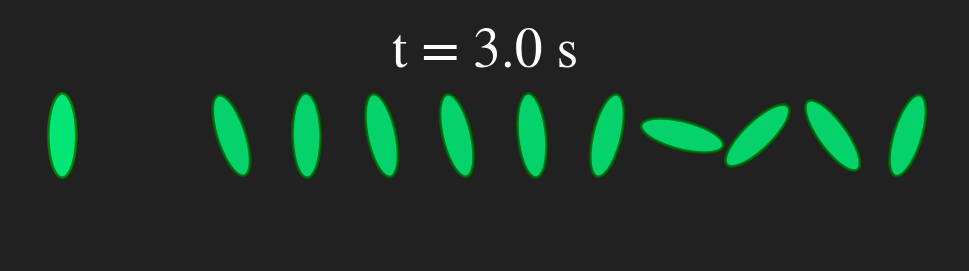

In [409]:
# simulation parameters
start_angle = 0.1
dt = .01
Dr = 0.1
ecoli_length = 0.2
ecoli_width = ecoli_length / 3.0 # Typical aspect ratio for E. coli (approx 3:1 to 5:1)
########################

### control glow effect
ampl = 5
T = 0.5
Tstep = int(T / dt)
########################

for i in range(N):
    d_vec_list.append(np.array([np.cos(start_angle), np.sin(start_angle)]))  # Initial unit vector

for i in range(300):
    fig, ax = plt.subplots(figsize=(6, 1.5), dpi=200, facecolor="#212121")
    angles_rad = np.arctan2(d2[1], d2[0])
    angles_deg = np.degrees(angles_rad) # Ellipse angle is in degrees
    draw_ecoli(ax, 0, 0, angles_deg,
                ecoli_length, ecoli_width,
                face_color='springgreen', edge_color='darkgreen',
                add_glow=True, glow_linewidth=ampl*np.sin(i/Tstep*2*np.pi), glow_alpha=0.5*(np.sin(i/Tstep*2*np.pi)+1.))
    for j in range(N):
        d_dot = calculate_d_dot(d_vec_list[j], omega_z_list[j], Gamma, E_tensor_list[j])
        d_vec_list[j] += d_dot * dt + Dr * np.random.choice([-1, 1])
        d_vec_list[j] /= np.linalg.norm(d_vec_list[j])  # Normalize to keep it a unit vector
        angles_rad = np.arctan2(d_vec_list[j][1], d_vec_list[j][0])
        angles_deg = np.degrees(angles_rad) # Ellipse angle is in degrees
        draw_ecoli(ax, r_list[j][0], r_list[j][1], angles_deg,
                   ecoli_length, ecoli_width,
                   face_color='springgreen', edge_color='darkgreen')
    plt.annotate(f"t = {i*dt:.1f} s", xy=(0.5, 0.8), xycoords="axes fraction", fontsize=20, ha="center", fontfamily="STIXGeneral", color="white")
    plt.axis("equal")
    plt.axis("off")
    plt.xlim(-.1, 2.1)
    fig.savefig(os.path.join(r"C:\Users\zl948\Documents\flow_align_animation\with_noise", f"{i:04d}.png"))
    plt.pause(0.01)
    clear_output(wait=True)
    # break

## 5 Visualize rotational speed components

I don't understand why at $x=0$, the adjacent particles would be rotated by the flow generated by the center particle. Here, I map out the two terms (rotation and extension) in 

$$
\dot{d}_i = \frac{1}{2} \epsilon_{ijk} \omega_j d_k + \Gamma d_k E_{kj} (\delta_{ji} - d_j d_i)
$$

aiming to understand how the flow would reorient particles. 

In [345]:
def calculate_d_dot_terms(d, omega_z, Gamma, E_tensor):
    """
    Calculates d_dot based on the 2D formulation.

    Args:
        d (np.ndarray): 2D unit vector d, shape (2,).
        omega_z (float): Vorticity component.
        Gamma (float): Scalar parameter.
        E_tensor (np.ndarray): 2x2 strain rate tensor, shape (2,2).

    Returns:
        np.ndarray: d_dot vector, shape (2,).
    """
    # Term 1: Rotation by vorticity
    # Rotation matrix for omega_z
    R_omega = np.array([[0, -1],
                        [1,  0]])
    term1 = 0.5 * omega_z * R_omega @ d

    # Term 2: Alignment by strain
    Ed = E_tensor @ d
    Ed_dot_d = np.dot(Ed, d)
    term2 = Gamma * (Ed - Ed_dot_d * d)

    d_dot = term1 + term2
    return term1, term2

In [375]:
term1_arr = np.zeros_like(x)
term2_arr = np.zeros_like(x)
d1 = np.array([1., 0.1])
d1 /= np.linalg.norm(d1)
d2 = np.array([0., 1.])
Gamma = 0.8

for i in range(x.shape[1]):
    for j in range(x.shape[2]):
        omega_z = compute_vorticity(x[:, i, j], d1)
        E_tensor = compute_strain_rate_tensor(x[:, i, j], d1)
        term1, term2 = calculate_d_dot_terms(d1, omega_z, Gamma, E_tensor)
        term1_arr[:, i, j] = term1
        term2_arr[:, i, j] = term2
        

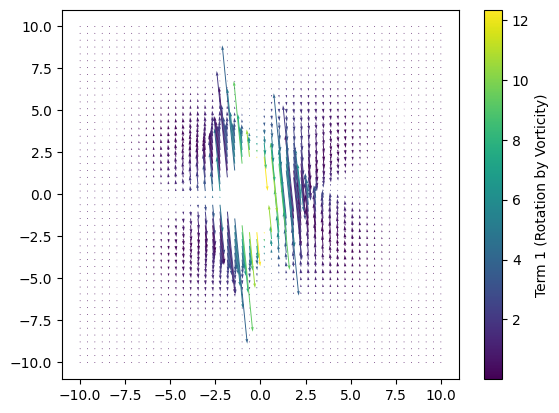

In [376]:
plt.quiver(X, Y, term1_arr[0], term1_arr[1], magnitude, cmap="viridis")
plt.colorbar(label="Term 1 (Rotation by Vorticity)")

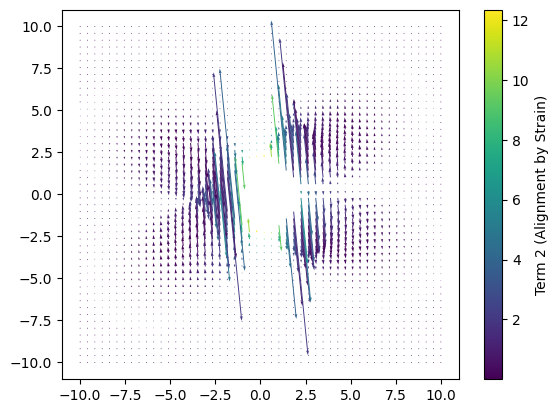

In [377]:
plt.quiver(X, Y, term2_arr[0], term2_arr[1], magnitude, cmap="viridis")
plt.colorbar(label="Term 2 (Alignment by Strain)")

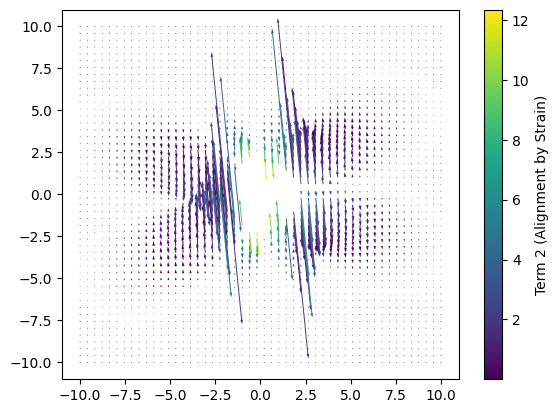

In [378]:
plt.quiver(X, Y, term1_arr[0]+term2_arr[0], term1_arr[1]+term2_arr[1], magnitude, cmap="viridis")
plt.colorbar(label="Term 2 (Alignment by Strain)")